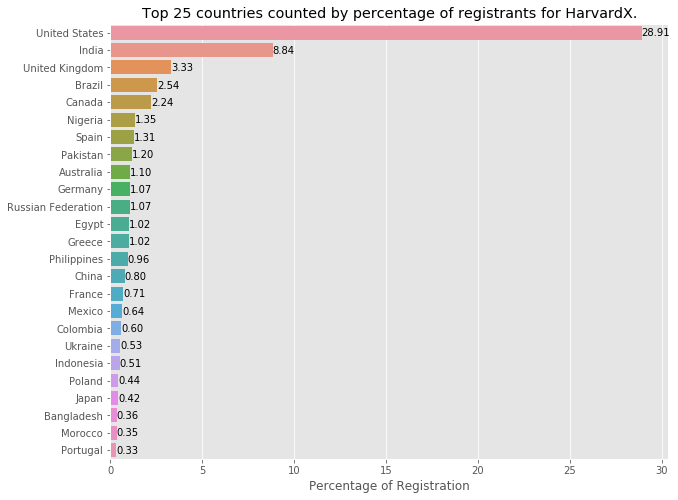

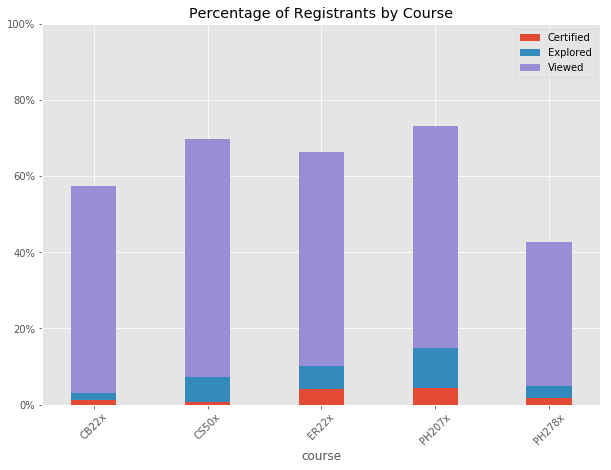

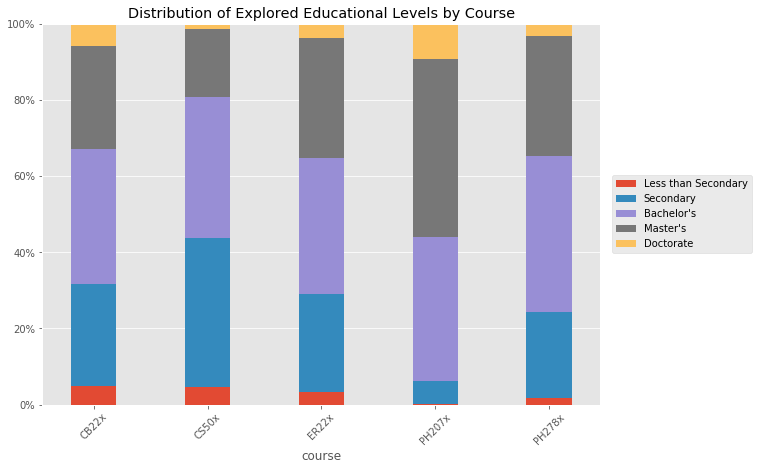

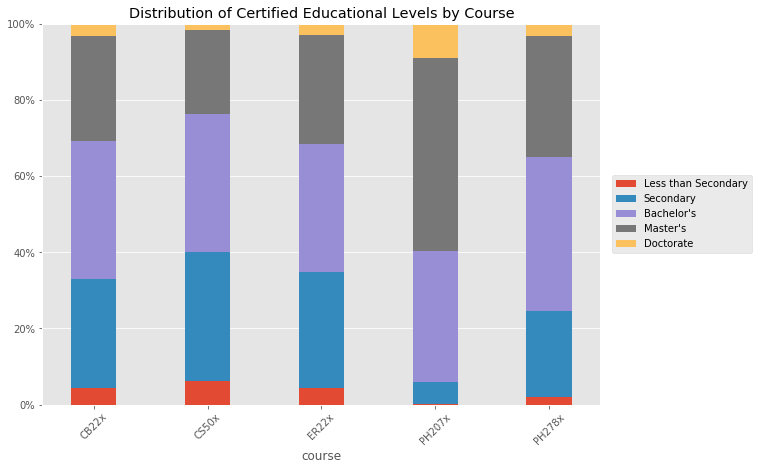

In [2]:
# Project - MOOCs
#
# This script aims to explore users behavior of open online courses.
#
# HarvardX Person-Course Academic Year 2013 De-Identified dataset, version 3.0
# Source: https://doi.org/10.7910/DVN/26147
#
# Author: Ming-Chen Lu
# Updated: Dec 29, 2019
#80: ---------------------------------------------------------------------------

# Set up: ----------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from scipy.stats import t
from statsmodels.formula.api import ols
%matplotlib inline
plt.style.use('ggplot')

# Read in the data: ------------------------------------------------------------
file = pd.read_csv("HXPC13_DI_v3_11-13-2019.csv")
#file.head()

# Data Preparation: ------------------------------------------------------------
# Split the course_id and delete roles showing all NAs
temp = file["course_id"].str.split("/", n = 2, expand = True)
file["institution"] = temp[0]
file["course"] = temp[1]
file["semester"] = temp[2]
file.drop(columns = ["course_id", "roles"], inplace = True)

# Geographical distribution of registrants: ------------------------------------
regions = pd.DataFrame(file.groupby("final_cc_cname_DI")['userid_DI']
                       .nunique(["userid_DI"])
                       .sort_values(ascending = False))
regions['pct'] =  (regions.values / regions.values.sum())*100
regions = regions[~regions.index.str.contains('Other')]

# Plot
plt.figure(figsize=(10, 8))
plt.title("Top 25 countries counted by percentage of registrants for HarvardX.")
bplot = sns.barplot(x=regions['pct'], y=regions.index)
bplot.set_xlabel('Percentage of Registration')
bplot.set_ylabel('')
for p in bplot.patches:
    width = p.get_width()
    bplot.text(width, p.get_y() + p.get_height()/2. + 0.2,
               '{:1.2f}'.format(width),
               ha="left")
## The plot shows that United States has the most registrant (28.91%), followed by 
## India (8.84%) and United Kingdom (3.33%).

# Activity Statistics: ---------------------------------------------------------
course = pd.pivot_table(file, index = ["course"], 
                         values = ["viewed", "explored", "certified"],
                         aggfunc = np.sum)

# compute the percentage
cnts = file.groupby(["course"]).size()
course['Certified'] = (course['certified'].values / cnts)*100
course['Explored'] = (course['explored'].values / cnts)*100
course['Viewed'] = (course['viewed'].values / cnts)*100

# plot
p1 = course.iloc[:,3:].plot.bar(stacked=True, figsize=(10,7), width = 0.4)
p1.set_ylim([0,100])
p1.yaxis.set_major_formatter(PercentFormatter())
p1.legend(loc = 1)
plt.xticks(rotation=45)
plt.title('Percentage of Registrants by Course')
plt.show()
    
# Explore users' learning activity with different educational levels: -----------
# remove the internally inconsistent records
file = file[file['incomplete_flag'] != 1]

# Extract key columns
df = file[['course', 'LoE_DI', 'explored', 'certified']]
df = df.dropna(axis = 0)

# Reorder LoE_DI
df['LoE_DI'] = ( df['LoE_DI'].astype('category').
                cat.reorder_categories(['Less than Secondary', 'Secondary', 
                                        "Bachelor's", "Master's", 'Doctorate']) )

# Percentage of users' educational level by course
edu = df.groupby(['course', 'LoE_DI']).sum()
edu = edu.groupby(level=0).apply(lambda x: 100 * x / x.sum())
edu = edu.reset_index()

# Plots: --------------------------------------------------------------------------
# prepare data
pivot_edu = edu.pivot(index = 'course', columns = 'LoE_DI', 
                      values = ['explored', 'certified'])

# Stacked bar plot - Explored
p2 = pivot_edu['explored'].plot.bar(stacked=True, figsize=(10,7), width = 0.4)

p2.set_ylim([0,100])
p2.yaxis.set_major_formatter(PercentFormatter())
p2.legend(loc = 'center right', bbox_to_anchor=(1.28, 0.5))
plt.xticks(rotation=45)
plt.title('Distribution of Explored Educational Levels by Course')
plt.show()

# Stacked bar plot - Certified
p3 = pivot_edu['certified'].plot.bar(stacked=True, figsize=(10,7), width = 0.4)

p3.set_ylim([0,100])
p3.yaxis.set_major_formatter(PercentFormatter())
p3.legend(loc = 'center right', bbox_to_anchor=(1.28, 0.5))
plt.xticks(rotation=45)
plt.title('Distribution of Certified Educational Levels by Course')
plt.show()